# Load packages

In [394]:
import numpy as np
import pandas as pd

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import koreanize_matplotlib #한글 깨짐 방지
import plotly.express as px

#날짜
from datetime import datetime

#확률분포
from scipy.stats import uniform, randint

#모델 저장
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor #다중공선성 VIF

#Scikit learn
from sklearn import tree
from sklearn.model_selection import train_test_split #데이터 분할
from sklearn.tree import plot_tree #결정트리 시각화
import graphviz #결정트리 시각화
from sklearn.tree import export_graphviz #결정트리 시각화
from sklearn.metrics import accuracy_score #정확도 구하기
from sklearn.pipeline import Pipeline #파이프라인
from sklearn.pipeline import make_pipeline # 특성공학 + 학습
from sklearn.impute import SimpleImputer # 결측값 단순 대치 기법
from sklearn.preprocessing import OneHotEncoder # 원핫인코딩(범주형변수 -> 수치형 변수)
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 분류
from sklearn.ensemble import RandomForestRegressor # 랜덤포레스트 회귀
from sklearn.ensemble import GradientBoostingClassifier # 그래디언트 부스트 분류
from sklearn.ensemble import GradientBoostingRegressor # 그래디언트 부스트 회귀
from sklearn.ensemble import AdaBoostClassifier #ada부스트 분류
from sklearn.tree import DecisionTreeClassifier #결정트리 분류
from sklearn.tree import DecisionTreeRegressor #결정트리 회귀
from sklearn.model_selection import GridSearchCV #그리드서치 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV #랜덤서치 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_predict #Cross Validation predict
from sklearn.metrics import r2_score #결정계수
from sklearn.linear_model import LinearRegression #선형회귀
from sklearn.metrics import r2_score #결정계수
from sklearn.metrics import mean_squared_error, root_mean_squared_error #MSE, RMSE
from sklearn.preprocessing import PolynomialFeatures #다항회귀
from sklearn.linear_model import Lasso #라쏘회귀
from sklearn.linear_model import Ridge #릿지회귀
from sklearn.linear_model import ElasticNet #엘라스틱넷 규제
from sklearn.preprocessing import StandardScaler #표준화
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score #f1 score
from sklearn.metrics import roc_auc_score, roc_curve #ROC 곡선
from sklearn.metrics import confusion_matrix #오차행렬(실제, 예측 행렬)
from sklearn.inspection import permutation_importance #변수의 중요도

# 들어가기에 앞서
- LinearRegression으로는 통계적 추론 정보(p-value, F-통계량 등)를 얻을 수 없다.
- 이것들은 statsmodels모델에서만 지원한다.
- 따라서 회귀계수, 결정계수로만 모델을 평가하자.
- 표준화를 한 후 계수의 크기, 또는 permutation_importance()함수로 변수의 중요도를 비교하자. (모델의 고도화를 위해)

# Load 따릉이 Data

In [395]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

train=train_data.copy()
test=test_data.copy() #원본 데이터 보호

In [396]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8040 non-null   object 
 1   Rented Bike Count          8040 non-null   int64  
 2   Hour                       8040 non-null   int64  
 3   Temperature(째C)            7240 non-null   float64
 4   Humidity(%)                8040 non-null   int64  
 5   Wind speed (m/s)           7238 non-null   float64
 6   Visibility (10m)           8040 non-null   int64  
 7   Dew point temperature(째C)  8040 non-null   float64
 8   Solar Radiation (MJ/m2)    8040 non-null   float64
 9   Rainfall(mm)               8040 non-null   float64
 10  Snowfall (cm)              8040 non-null   float64
 11  Seasons                    7238 non-null   object 
 12  Holiday                    8040 non-null   object 
 13  Functioning Day            8040 non-null   objec

In [397]:
train.head(2)

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,NaN,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


- Date : 날짜 (요일과 월로 분리하자)
- Rented Bike Count : 대여 대수 (종속변수)
- Hour : 계측한 시간
- Temperature : 온도
- Humidity : 습도
- Wind speed : 바람세기
- Visibility : 가시거리
- Dew point temperature : 이슬점
- Solar Radiation : 자외선 지수
- Rainfall : 강우량
- Snowfall : 강수량
- Seasons : 계절
- Holiday : 연휴 여부
- Functioning Day : 근무일 여부

## 1. 결측치

In [398]:
train.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(째C)              800
Humidity(%)                    0
Wind speed (m/s)             802
Visibility (10m)               0
Dew point temperature(째C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      802
Holiday                        0
Functioning Day                0
dtype: int64

전체 데이터중 10%가 결측치이다. 이를 제거해도 무방할것 같다.

보간하는 방법은 어떨까? 이 방법은 너무 복잡하다. 
<br>회귀분석 또는 분류분석으로 결측치를 보간한 다음 다시 이걸 토대로 회귀분석? 
<br>오류가 쌓이고 쌓여 나비효과를 불러일으킬 것 같다.

따라서 그냥 제거하는 것으로 하자.

In [399]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       720 non-null    object 
 1   Hour                       720 non-null    int64  
 2   Temperature(째C)            644 non-null    float64
 3   Humidity(%)                720 non-null    int64  
 4   Wind speed (m/s)           646 non-null    float64
 5   Visibility (10m)           720 non-null    int64  
 6   Dew point temperature(째C)  720 non-null    float64
 7   Solar Radiation (MJ/m2)    720 non-null    float64
 8   Rainfall(mm)               720 non-null    float64
 9   Snowfall (cm)              720 non-null    float64
 10  Seasons                    646 non-null    object 
 11  Holiday                    720 non-null    object 
 12  Functioning Day            720 non-null    object 
dtypes: float64(6), int64(3), object(4)
memory usage: 7

test데이터에는 Rented Bike Count이 없다

In [400]:
test.isna().sum()

Date                          0
Hour                          0
Temperature(째C)              76
Humidity(%)                   0
Wind speed (m/s)             74
Visibility (10m)              0
Dew point temperature(째C)     0
Solar Radiation (MJ/m2)       0
Rainfall(mm)                  0
Snowfall (cm)                 0
Seasons                      74
Holiday                       0
Functioning Day               0
dtype: int64

test데이터도 결측치가 전체 데이터중 10%를 차지하므로 단순 제거해도 무방할 것 같다.

In [401]:
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       5851 non-null   object 
 1   Rented Bike Count          5851 non-null   int64  
 2   Hour                       5851 non-null   int64  
 3   Temperature(째C)            5851 non-null   float64
 4   Humidity(%)                5851 non-null   int64  
 5   Wind speed (m/s)           5851 non-null   float64
 6   Visibility (10m)           5851 non-null   int64  
 7   Dew point temperature(째C)  5851 non-null   float64
 8   Solar Radiation (MJ/m2)    5851 non-null   float64
 9   Rainfall(mm)               5851 non-null   float64
 10  Snowfall (cm)              5851 non-null   float64
 11  Seasons                    5851 non-null   object 
 12  Holiday                    5851 non-null   object 
 13  Functioning Day            5851 non-null   object 
dt

800개가 아닌 2200개의 데이터가 삭제되었다! 서로 중복되는 결측치 행이 없었나 보다.<br>
하지만 데이터가 너무 많으면 overfit이 될 가능성이 높으니 계속 진행하자

In [402]:
test.dropna(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 719
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       516 non-null    object 
 1   Hour                       516 non-null    int64  
 2   Temperature(째C)            516 non-null    float64
 3   Humidity(%)                516 non-null    int64  
 4   Wind speed (m/s)           516 non-null    float64
 5   Visibility (10m)           516 non-null    int64  
 6   Dew point temperature(째C)  516 non-null    float64
 7   Solar Radiation (MJ/m2)    516 non-null    float64
 8   Rainfall(mm)               516 non-null    float64
 9   Snowfall (cm)              516 non-null    float64
 10  Seasons                    516 non-null    object 
 11  Holiday                    516 non-null    object 
 12  Functioning Day            516 non-null    object 
dtypes: float64(6), int64(3), object(4)
memory usage: 56.4+ 

test데이터도 많이 데이터가 사라졌지만 그대로 진행한다

## 2-1. 변수 변환 - 범주형

- 원핫인코딩을 사용하자

In [403]:
train.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [404]:
#연속형변수
cont_var=['Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

### 1) Date

연도, 월, 요일을 각각 분리해보자

In [405]:
train['date'] = pd.to_datetime(train['Date'], format="%d/%m/%Y")
test['date'] = pd.to_datetime(test['Date'], format="%d/%m/%Y")

In [406]:
train['year'] = train['date'].dt.year # 연도
train['month'] = train['date'].dt.month # 월
train['weekday'] = train['date'].dt.day_name() # 요일

test['year'] = test['date'].dt.year # 연도
test['month'] = test['date'].dt.month # 월
test['weekday'] = test['date'].dt.day_name() # 요일

In [407]:
train.drop(["Date","date"], axis=1, inplace=True)
test.drop(["Date","date"], axis=1, inplace=True)

In [408]:
train.head(2)

,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,year,month,weekday
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday


잘 되었다.

In [409]:
train.columns.difference(cont_var)

Index(['Functioning Day', 'Holiday', 'Hour', 'Rented Bike Count', 'Seasons',
       'month', 'weekday', 'year'],
      dtype='object')

'Rented Bike Count'는 종속변수임을 유의하자

In [410]:
cat_var=['Functioning Day', 'Holiday', 'Hour', 'month', 'weekday', 'year', 'Seasons']

### 2) 수치형 데이터를 범주형 데이터로 변환

In [411]:
train[cat_var].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 8039
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Functioning Day  5851 non-null   object
 1   Holiday          5851 non-null   object
 2   Hour             5851 non-null   int64 
 3   month            5851 non-null   int32 
 4   weekday          5851 non-null   object
 5   year             5851 non-null   int32 
 6   Seasons          5851 non-null   object
dtypes: int32(2), int64(1), object(4)
memory usage: 320.0+ KB


In [412]:
train[cat_var]=train[cat_var].astype("category")
test[cat_var]=test[cat_var].astype("category")

In [413]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 8039
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Rented Bike Count          5851 non-null   int64   
 1   Hour                       5851 non-null   category
 2   Temperature(째C)            5851 non-null   float64 
 3   Humidity(%)                5851 non-null   int64   
 4   Wind speed (m/s)           5851 non-null   float64 
 5   Visibility (10m)           5851 non-null   int64   
 6   Dew point temperature(째C)  5851 non-null   float64 
 7   Solar Radiation (MJ/m2)    5851 non-null   float64 
 8   Rainfall(mm)               5851 non-null   float64 
 9   Snowfall (cm)              5851 non-null   float64 
 10  Seasons                    5851 non-null   category
 11  Holiday                    5851 non-null   category
 12  Functioning Day            5851 non-null   category
 13  year                       5851 non-nu

### 3) 원핫 인코딩과 레퍼런스 코딩

In [414]:
train_cat=pd.get_dummies(train[cat_var], drop_first=True) #원핫인코딩과 레퍼런스코딩을 동시에 진행
test_cat=pd.get_dummies(test[cat_var], drop_first=True)
train_cat

,Functioning Day_Yes,Holiday_No Holiday,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,...,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,year_2018,Seasons_Spring,Seasons_Summer,Seasons_Winter
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,True,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,True,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,True,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
8033,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
8037,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
8038,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False


## 2-2. 변수 변환 - 연속형

수치형 변수중에서 명목형 변수가 아닌 연속형 변수만 변환을 하자

pipeline을 통해서 할수도 있지만 미리 처리하는 것도 좋은 방법이다.

In [415]:
scaler=StandardScaler()

In [416]:
train[cont_var] = scaler.fit_transform(train[cont_var])

In [417]:
train[cont_var]

,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
1,-1.560119,-0.995348,-0.921211,0.900033,-1.678560,-0.671255,-0.136765,-0.17456
2,-1.600938,-0.946252,-0.729420,0.900033,-1.686065,-0.671255,-0.136765,-0.17456
3,-1.617266,-0.897155,-0.825316,0.900033,-1.678560,-0.671255,-0.136765,-0.17456
5,-1.633594,-1.044445,-0.249942,0.900033,-1.761124,-0.671255,-0.136765,-0.17456
7,-1.715234,-0.995348,-0.825316,0.900033,-1.806159,-0.671255,-0.136765,-0.17456
...,...,...,...,...,...,...,...,...
8029,-0.196740,-1.191734,0.804911,0.800758,-0.665266,1.848560,-0.136765,-0.17456
8033,-0.188576,-0.848058,0.037745,0.900033,-0.462608,-0.102624,-0.136765,-0.17456
8037,-0.490642,0.035679,1.188493,0.782557,-0.357525,-0.671255,-0.136765,-0.17456
8038,-0.555953,-0.013417,0.421328,0.794139,-0.425078,-0.671255,-0.136765,-0.17456


train데이터셋에 맞춘 것을 이용해 test도 표준화를 하자 (평균과 표준편차를 공유)

In [418]:
test[cont_var] = scaler.transform(test[cont_var])

In [419]:
test[cont_var]

,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,-0.645757,0.182969,0.517224,0.749465,-0.432584,-0.671255,-0.136765,-0.17456
1,-0.694740,0.330258,-0.154046,0.787521,-0.425078,-0.671255,-0.136765,-0.17456
3,-0.768216,0.330258,-1.017107,0.837159,-0.492631,-0.671255,-0.136765,-0.17456
4,-0.817200,0.575741,-0.921211,0.790830,-0.455102,-0.671255,-0.136765,-0.17456
5,-0.841691,0.673934,-1.688376,0.810685,-0.447596,-0.671255,-0.136765,-0.17456
...,...,...,...,...,...,...,...,...
714,-0.727396,-1.191734,0.133641,0.339125,-1.093101,-0.671255,-0.136765,-0.17456
716,-0.833527,-1.044445,0.517224,0.900033,-1.100607,-0.671255,-0.136765,-0.17456
717,-0.898839,-0.946252,-1.400690,0.847086,-1.100607,-0.671255,-0.136765,-0.17456
718,-0.939659,-0.848058,-0.729420,0.666735,-1.093101,-0.671255,-0.136765,-0.17456


## 2-3. 둘을 다시 합치기

In [420]:
train=pd.concat([train['Rented Bike Count'],train[cont_var],train_cat], axis=1)
train

,Rented Bike Count,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day_Yes,...,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,year_2018,Seasons_Spring,Seasons_Summer,Seasons_Winter
1,204,-1.560119,-0.995348,-0.921211,0.900033,-1.678560,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,False,False,False,False,True
2,173,-1.600938,-0.946252,-0.729420,0.900033,-1.686065,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,False,False,False,False,True
3,107,-1.617266,-0.897155,-0.825316,0.900033,-1.678560,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,False,False,False,False,True
5,100,-1.633594,-1.044445,-0.249942,0.900033,-1.761124,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,False,False,False,False,True
7,460,-1.715234,-0.995348,-0.825316,0.900033,-1.806159,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,983,-0.196740,-1.191734,0.804911,0.800758,-0.665266,1.848560,-0.136765,-0.17456,True,...,False,False,False,False,False,True,True,False,False,False
8033,1462,-0.188576,-0.848058,0.037745,0.900033,-0.462608,-0.102624,-0.136765,-0.17456,True,...,False,False,False,False,False,True,True,False,False,False
8037,1069,-0.490642,0.035679,1.188493,0.782557,-0.357525,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,True,True,False,False,False
8038,1088,-0.555953,-0.013417,0.421328,0.794139,-0.425078,-0.671255,-0.136765,-0.17456,True,...,False,False,False,False,False,True,True,False,False,False


In [421]:
#test에는 Rented Bike Count가 없음
test=pd.concat([test[cont_var],test_cat], axis=1)
test

,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day_Yes,Hour_1,...,Hour_20,Hour_21,Hour_22,Hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,-0.645757,0.182969,0.517224,0.749465,-0.432584,-0.671255,-0.136765,-0.17456,True,False,...,False,False,False,False,False,False,False,True,False,False
1,-0.694740,0.330258,-0.154046,0.787521,-0.425078,-0.671255,-0.136765,-0.17456,True,True,...,False,False,False,False,False,False,False,True,False,False
3,-0.768216,0.330258,-1.017107,0.837159,-0.492631,-0.671255,-0.136765,-0.17456,True,False,...,False,False,False,False,False,False,False,True,False,False
4,-0.817200,0.575741,-0.921211,0.790830,-0.455102,-0.671255,-0.136765,-0.17456,True,False,...,False,False,False,False,False,False,False,True,False,False
5,-0.841691,0.673934,-1.688376,0.810685,-0.447596,-0.671255,-0.136765,-0.17456,True,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,-0.727396,-1.191734,0.133641,0.339125,-1.093101,-0.671255,-0.136765,-0.17456,True,False,...,False,False,False,False,False,False,False,False,False,False
716,-0.833527,-1.044445,0.517224,0.900033,-1.100607,-0.671255,-0.136765,-0.17456,True,False,...,True,False,False,False,False,False,False,False,False,False
717,-0.898839,-0.946252,-1.400690,0.847086,-1.100607,-0.671255,-0.136765,-0.17456,True,False,...,False,True,False,False,False,False,False,False,False,False
718,-0.939659,-0.848058,-0.729420,0.666735,-1.093101,-0.671255,-0.136765,-0.17456,True,False,...,False,False,True,False,False,False,False,False,False,False


## 3. 독립, 종속변수

In [422]:
X=train.drop("Rented Bike Count", axis=1)
Y=train["Rented Bike Count"].copy()

test데이터에는 Rented Bike Count이 없다. 따라서 이것은 검정 데이터가 아님에 유의하자(근데 왜 이름은 test??)

## 4. 데이터 분할

In [423]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234) 

# Predict Count

## 0. 회귀모델 평가함수

In [424]:
def eval_regression(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    
    #MAPE를 구하는데 inf값이 나와 오류가 발생
    train_finite_values = np.abs((Y_train - Y_train_pred) / Y_train)
    train_finite_values = train_finite_values[np.isfinite(train_finite_values)]
    train_MAPE=train_finite_values.mean()*100
    
    test_finite_values = np.abs((Y_test - Y_test_pred) / Y_test)
    test_finite_values = test_finite_values[np.isfinite(test_finite_values)]
    test_MAPE=test_finite_values.mean()*100
    
    print('학습 능력')
    print('학습 결정계수 : ', r2_score(Y_train, Y_train_pred))
    print('학습 RMSE : ', root_mean_squared_error(Y_train, Y_train_pred))
    print('학습 MAPE : ', train_MAPE,'%')
    print("\n")
    print('일반화 능력')
    print('검정 결정계수 : ', r2_score(Y_test, Y_test_pred))
    print('검정 RMSE : ', root_mean_squared_error(Y_test, Y_test_pred))
    print('검정 MAPE : ', test_MAPE)

## 1. 선형회귀모델

### 모델 생성

In [425]:
linear_model=LinearRegression(copy_X=True, n_jobs=-1)
#copy_X : 데이터 복사하여 사용
#n_jobs : cpu 사용 개수

In [426]:
linear_model.fit(X_train, Y_train)

LinearRegression(n_jobs=-1)

In [427]:
eval_regression(linear_model)

학습 능력
학습 결정계수 :  0.7087428687620676
학습 RMSE :  355.69788835086797
학습 MAPE :  164.5558080337382 %


일반화 능력
검정 결정계수 :  0.6785732219922888
검정 RMSE :  379.2054420432155
검정 MAPE :  180.05752130455414


- 결정계수 : 모델이 전체 데이터의 약 70% 정도 설명한다
- RMSE : 다른 모델과 비교해보자
- MAPE : 예측값이 실제값과 약 64~80%정도 차이난다

### 회귀계수 비교

In [428]:
linear_coef = pd.DataFrame()
linear_coef['coef'] = linear_model.coef_
linear_coef['variable'] = linear_model.feature_names_in_
linear_coef

,coef,variable
0,2.200278e+02,Temperature(째C)
1,-1.646432e+02,Humidity(%)
2,2.369044e+00,Wind speed (m/s)
3,3.150390e+01,Visibility (10m)
4,1.059708e+02,Dew point temperature(째C)
5,4.736458e+01,Solar Radiation (MJ/m2)
6,-8.483583e+01,Rainfall(mm)
7,1.540172e+01,Snowfall (cm)
8,1.042245e+03,Functioning Day_Yes
9,1.366507e+02,Holiday_No Holiday


In [429]:
px.bar(linear_coef.query("variable in @cont_var"), x="variable", y="coef", title="표준화변수(연속형변수)")

- 온도 변수의 긍정적 영향이 제일 크고, 온도가 높을수록 대여량이 상승한다.
- 습도 변수의 부정적 영향이 제일 크고, 습도가 낮을수록 대여량이 감소한다. (춥다 -> 습도가 낮다?)
- 풍속은 거의 영향이 없다 (제거해도 될듯)
- 이슬점과 강우량이 서로 반대 영향을 준다 (과학은 잘 몰라요)
- 자외선 지수가 높을수록 대여량이 늘어난다? 아마 기온, 날씨와 관계있을텐데, 근데 자외선지수가 너무 쌔면 아무도 안타지 않을까? 아래에서 확인해보자.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_core\plot.py:1043: UserWarning:

Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) Arial.



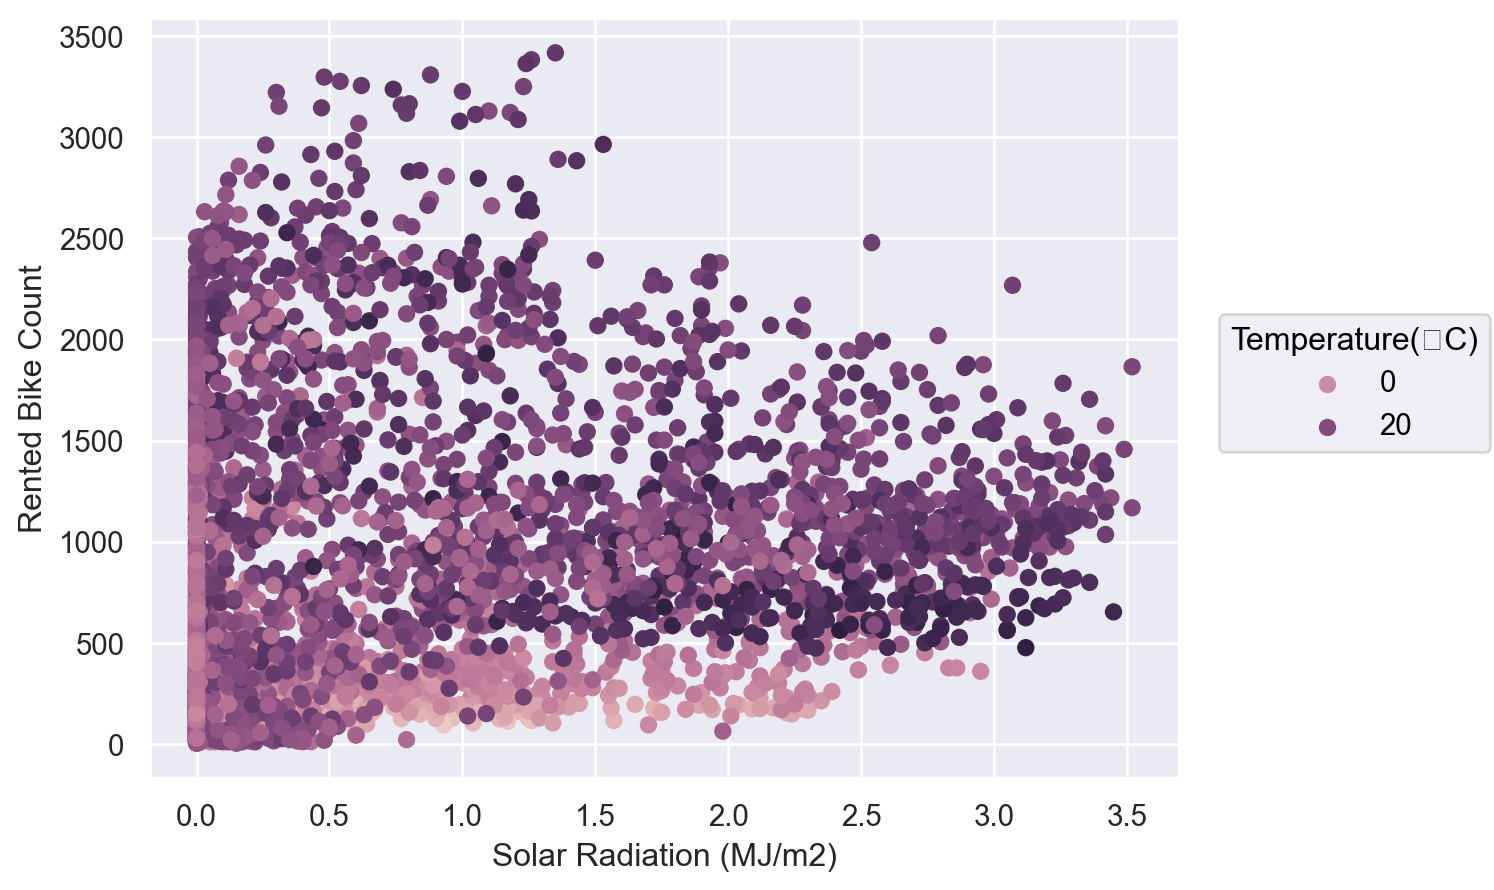

In [430]:
(
    so.Plot(train_data.dropna().query("`Rented Bike Count` != 0"), x="Solar Radiation (MJ/m2)", y="Rented Bike Count"
            , color="Temperature(째C)")
    .add(so.Dot())
)

잘 모르겠다. 하나 확실한건 자외선 지수가 극심할때에는 대여량이 그리 많지 않다는 점이다.

In [431]:
px.bar(linear_coef.query("variable not in @cont_var"), x="variable", y="coef", title="범주형변수")


일부 변수들의 회귀계수가 너무 커서 나머지 변수의 영향이 거의 없어보이게 되었다. overfit이 발생한 것 같다.
<br>왜냐하면 6,7,8월에 대여량이 증가하는데, 가을대비 여름에 대여량이 크게 감소한다고? 대체 가을이 몇월이길래 이러는건지

### overfit 해결하기

Seasons변수를 제거하기 다시 해보자

In [432]:
linear_model_s=LinearRegression(copy_X=True, n_jobs=-1)

In [433]:
X_train_s = X_train.drop(columns=X_train.filter(like="Seasons").columns)

In [434]:
linear_model_s.fit(X_train_s, Y_train)

LinearRegression(n_jobs=-1)

In [435]:
linear_coef_s = pd.DataFrame()
linear_coef_s['coef'] = linear_model_s.coef_
linear_coef_s['variable'] = linear_model_s.feature_names_in_

In [436]:
px.bar(linear_coef_s.query("variable in @cont_var"), x="variable", y="coef", title="표준화변수(연속형변수)")

연속형 변수는 별 차이 없다

In [437]:
px.bar(linear_coef_s.query("variable not in @cont_var"), x="variable", y="coef", title="범주형변수")


?? 12월에 따릉이 대여량이 폭증한다고? 모델이 엄청 망가진것 같다.
<br>차라리 month를 제거해보자

In [438]:
linear_model_m=LinearRegression(copy_X=True, n_jobs=-1)
X_train_m = X_train.drop(columns=X_train.filter(like="month").columns)
linear_model_m.fit(X_train_m, Y_train)

linear_coef_m = pd.DataFrame()
linear_coef_m['coef'] = linear_model_m.coef_
linear_coef_m['variable'] = linear_model_m.feature_names_in_

px.bar(linear_coef_m.query("variable not in @cont_var"), x="variable", y="coef", title="범주형변수")


- month변수를 제거하는것이 정답이었다.
- X_train, test변수에서 month를 제거하고 처음부터 다시 하자

### 최종 선형회귀모델

데이터를 다시 처음부터 전처리하기

In [439]:
train=train_data.copy()
test=test_data.copy()
train.dropna(inplace=True)
test.dropna(inplace=True)

train['date'] = pd.to_datetime(train['Date'], format="%d/%m/%Y")
test['date'] = pd.to_datetime(test['Date'], format="%d/%m/%Y")
train['year'] = train['date'].dt.year # 연도
train['month'] = train['date'].dt.month # 월
train['weekday'] = train['date'].dt.day_name() # 요일
test['year'] = test['date'].dt.year # 연도
test['month'] = test['date'].dt.month # 월
test['weekday'] = test['date'].dt.day_name() # 요일
train.drop(["Date","date"], axis=1, inplace=True)
test.drop(["Date","date"], axis=1, inplace=True)

train[cat_var]=train[cat_var].astype("category")
test[cat_var]=test[cat_var].astype("category")

train_cat=pd.get_dummies(train[cat_var], drop_first=True)
test_cat=pd.get_dummies(test[cat_var], drop_first=True)

scaler=StandardScaler()
train[cont_var] = scaler.fit_transform(train[cont_var])
test[cont_var] = scaler.transform(test[cont_var])

train=pd.concat([train['Rented Bike Count'],train[cont_var],train_cat], axis=1)
test=pd.concat([test[cont_var],test_cat], axis=1)

train.drop(columns=X_train.filter(like="month").columns, inplace=True)
test.drop(columns=test.filter(like="month").columns, inplace=True)

X=train.drop("Rented Bike Count", axis=1)
Y=train["Rented Bike Count"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234) 

In [440]:
linear_model=LinearRegression(copy_X=True, n_jobs=-1)
linear_model.fit(X_train, Y_train)

linear_coef = pd.DataFrame()
linear_coef['coef'] = linear_model.coef_
linear_coef['variable'] = linear_model.feature_names_in_


In [441]:
eval_regression(linear_model)

학습 능력
학습 결정계수 :  0.6711948430812763
학습 RMSE :  377.9308230759022
학습 MAPE :  160.00431539448635 %


일반화 능력
검정 결정계수 :  0.649316930066911
검정 RMSE :  396.0873147787638
검정 MAPE :  179.54748169473515


- 결정계수 : 생성한 모델이 데이터의 약 65% 정도 해석한다
- MAPE : 예측한 데이터가 실제 데이터랑 평균 60~80% 차이난다

In [442]:
px.bar(linear_coef.query("variable in @cont_var"), x="variable", y="coef", title="표준화변수(연속형변수)")

연속형 변수에 대한 것은 앞과 거의 비슷하다.

In [443]:
px.bar(linear_coef.query("variable not in @cont_var"), x="variable", y="coef", title="범주형변수")

- 근무날에 따릉이 대여량이 폭증한다
- 연휴에는 따릉이 대여량이 소폭 감소한다
- 새벽에는 대여량이 감고, 7시에 증가(출근시간), 이후 15시까지 감소, 이후 증가하다 17~21시까지 정점 (퇴근시간)
- 요일은 다른 변수들에 비해 영향이 적지만, 금, 토, 일에 줄어드는 경향을 보인다.
- 가을에 제일 대여량이 많고 여름, 봄, 겨울 순으로 대여량이 감소한다

각 변수의 신뢰도를 보고싶지만 그건 statsmodels모델에서만 가능하므로 패스

## 2. 다항회귀분석

In [444]:
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lin_reg', LinearRegression())
])

In [445]:
poly_model.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('lin_reg', LinearRegression())])

In [446]:
print(eval_regression(linear_model))
print("\n")
print(eval_regression(poly_model))

학습 능력
학습 결정계수 :  0.6711948430812763
학습 RMSE :  377.9308230759022
학습 MAPE :  160.00431539448635 %


일반화 능력
검정 결정계수 :  0.649316930066911
검정 RMSE :  396.0873147787638
검정 MAPE :  179.54748169473515
None


학습 능력
학습 결정계수 :  0.9091832998427302
학습 RMSE :  198.621319172428
학습 MAPE :  77.27986620672888 %


일반화 능력
검정 결정계수 :  0.6187010534372025
검정 RMSE :  413.01548673830285
검정 MAPE :  132.17776005371664
None


다항회귀분석의 경우
- 학습 결정계수가 검정 분석과 달리 0.9가까이 치솟았다 -> 과적합 가능성 농후
- 선형회귀모델과 비교하여 RMSE는 학습의 경우 줄어들었지만 검정의 경우 소폭 상승하였다.
- MAPE는 30%로 줄어들어 꽤 좋은 모습을 보이고 있다. 

In [447]:
len(poly_model.named_steps['lin_reg'].coef_)

990

회귀계수의 크기를 비교하는건 의미 없는듯.. 990개나 되는걸 언제 다 비교해

## 3. Lasso 회귀모델

## 4. Ridge 회귀모델

## 5. Elastic Net

# Result